In [4]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import re


In [5]:
def feature_extractor(sound_path, window_size):
    # Load the audio file
    signal, sr = librosa.load(sound_path)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13,sr = sr, hop_length=window_size)
    
    # Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [6]:
def build_dataset(sound_path='/kaggle/input/tamil-digits/Tamil-Digits', window_size=512, is_pca = 0, num_pca_comp = 13):
    # Define the path to the sound files
    path = Path(sound_path)
    # Retrieve the list of files in the directory
    files = sorted([file for file in path.iterdir() if file.is_file()])
    
    # Initialize lists to store training and testing data
    Train = []
    Test = []
    
    # Initialize a dictionary to store data for each digit
    data = dict()
    
    # Get the total number of files
    n = len(files)
    # Iterate over each file
    for i in range(n):
        print(str(files[i]))
        # Extract features from the current file
        feature = feature_extractor(sound_path=str(files[i]), window_size=window_size)[3]
        
         # Extract the digit label from the filename
        digit = files[i].name[0]

        transposed_mfcc = feature.T

        # Create a DataFrame from the transposed array
        df = pd.DataFrame(transposed_mfcc)
        
        if is_pca == 1:
                pca = PCA(n_components=num_pca_comp)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)


        # Add the file name as the first column
        df.insert(0, 'File Name', os.path.basename(files[i]))
        df.insert(1, 'digit', digit)

        # Optionally, you can rename the columns if you want
        column_names = ['File Name'] + ['digit'] + [f"Feature_{i+1}" for i in range(df.shape[1]-2)]
        df.columns = column_names

        # Check if the digit is already in the data dictionary
        if digit not in data.keys():
            # If not, create a new list for that digit
            data[digit] = []
            # Append the feature to the test set
            Test.append(df)
        else:
            # If the digit is already in the dictionary
            if np.random.rand() < 0.1:
                # Randomly assign 10% of the samples to the test set
                Test.append(df)
                
            else:
                # Assign the rest of the samples to the training set
                Train.append(df)
            
            # Append the feature to the data dictionary
        data[digit].append(feature)
    # Concatenate all DataFrames into a single DataFrame
    Training = pd.concat(Train, ignore_index=True)
    Testing = pd.concat(Test, ignore_index=True)
    # Return the training and testing data along with the data dictionary
    return Training, Testing, data


In [8]:
#Experiment Here 
cwd = os.getcwd()

# Go one folder back
parent_dir = os.path.dirname(cwd)

# Specify the relative path to the audio file from the parent directory
relative_path = r"Dataset\HindiDigits"
relative_path_mfcc = r"Dataset\HindiDigitsMFCC"

speech_path = os.path.join(parent_dir, relative_path)
audio_file  = speech_path + r"\1_01.wav"
signal, sr = librosa.load(audio_file)
    
# Call the feature_extractor function with window size (default is 512 generated 68 frames for the given audio file)
# Changing to 256 gives 135 frames
a, b, c, d = feature_extractor(audio_file,512)
d.shape


(39, 12)

In [5]:
def MelSpectrogram(mfccs, delta_mfccs, delta2_mfccs, mfccs_features):
    print("MFCCs shape:", mfccs.shape)
    print("Delta MFCCs shape:", delta_mfccs.shape)
    print("Delta2 MFCCs shape:", delta2_mfccs.shape)
    print("Concatenated MFCCs features shape:", mfccs_features.shape)
    
    # Plot MFCCs
    plt.figure(figsize=(25, 10))
    plt.subplot(3, 1, 1)
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs')
    
    # Plot delta MFCCs
    plt.subplot(3, 1, 2)
    librosa.display.specshow(delta_mfccs, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Delta MFCCs')
    
    # Plot delta2 MFCCs
    plt.subplot(3, 1, 3)
    librosa.display.specshow(delta2_mfccs, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Delta2 MFCCs')
    
    plt.tight_layout()
    plt.show()


MFCCs shape: (13, 68)
Delta MFCCs shape: (13, 68)
Delta2 MFCCs shape: (13, 68)
Concatenated MFCCs features shape: (39, 68)


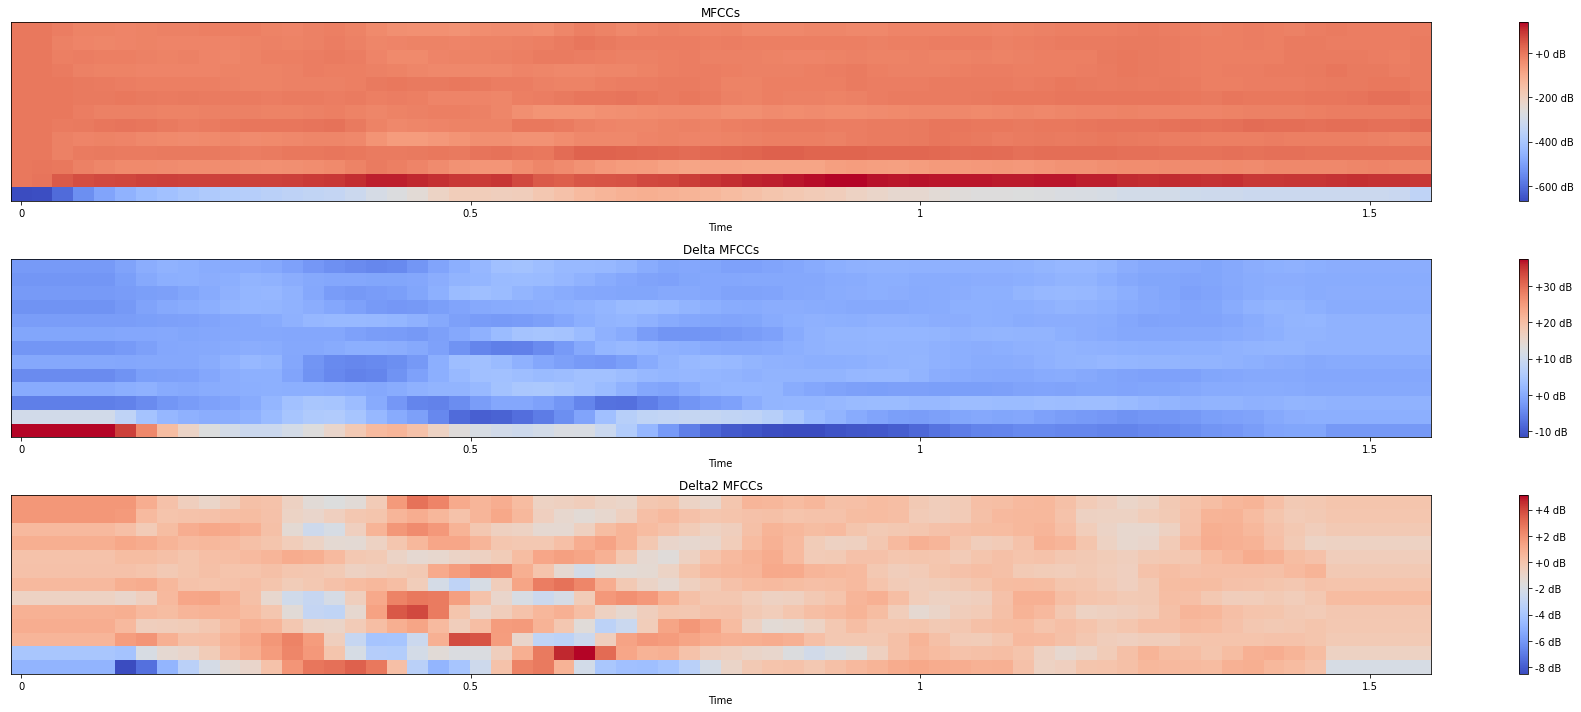

In [52]:
# Assuming you have the sampling rate stored in a variable named `sr`
MelSpectrogram(a, b, c, d)

In [10]:
#!!! Main change to be done here
#Change Window size here
Training, Testing, data = build_dataset(sound_path=speech_path,window_size=256,is_pca=1, num_pca_comp=13)
# Define the output directory
output_folder =  os.path.join(parent_dir, relative_path_mfcc)
   # Output directory

# Check if the output directory exists, if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save DataFrame as CSV in the output directory
output_file = os.path.join(output_folder,"Train.csv")
Training.to_csv(output_file, index=False)
output_file = os.path.join(output_folder,"Test.csv")
Testing.to_csv(output_file, index=False)


c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_01.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_02.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_03.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_04.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_05.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_06.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_07.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_08.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_09.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_10.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_11.wav
c:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\Dataset\HindiDigits\1_12.wav
c:\Users\Rashaad